In [69]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# ResNet50
from tensorflow.python.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50

# Xception
from tensorflow.python.keras.applications import Xception
from tensorflow.keras.applications import xception

from split_train_valid_subdir import split_train_valid_test_subdir

Within this notebook we will build two classifiers using weights of ResNet50 and Xception trained on ImageNet dataset, retraining only the output layers to fit our purposes (boats classification).

# Explore and Prepare data

We downloaded the boats dataset from Kaggle at: https://www.kaggle.com/clorichel/boat-types-recognition/version/1 

In [68]:
tot_obs = sum([len(os.listdir('train'+'/' + label))-1 for label in os.listdir('train')])
for label in os.listdir('train'):
    print(label,np.round((len(os.listdir('train'+'/' + label))-1)/tot_obs*100,2),'%')

buoy 4.76 %
inflatable boat 1.63 %
gondola 17.31 %
paper boat 3.6 %
kayak 16.61 %
sailboat 32.64 %
ferry boat 5.46 %
freight boat 2.21 %
cruise ship 15.8 %


We observe that the dataset is unbalanced.

In [2]:
# just once!
split_train_valid_test_subdir('boats')

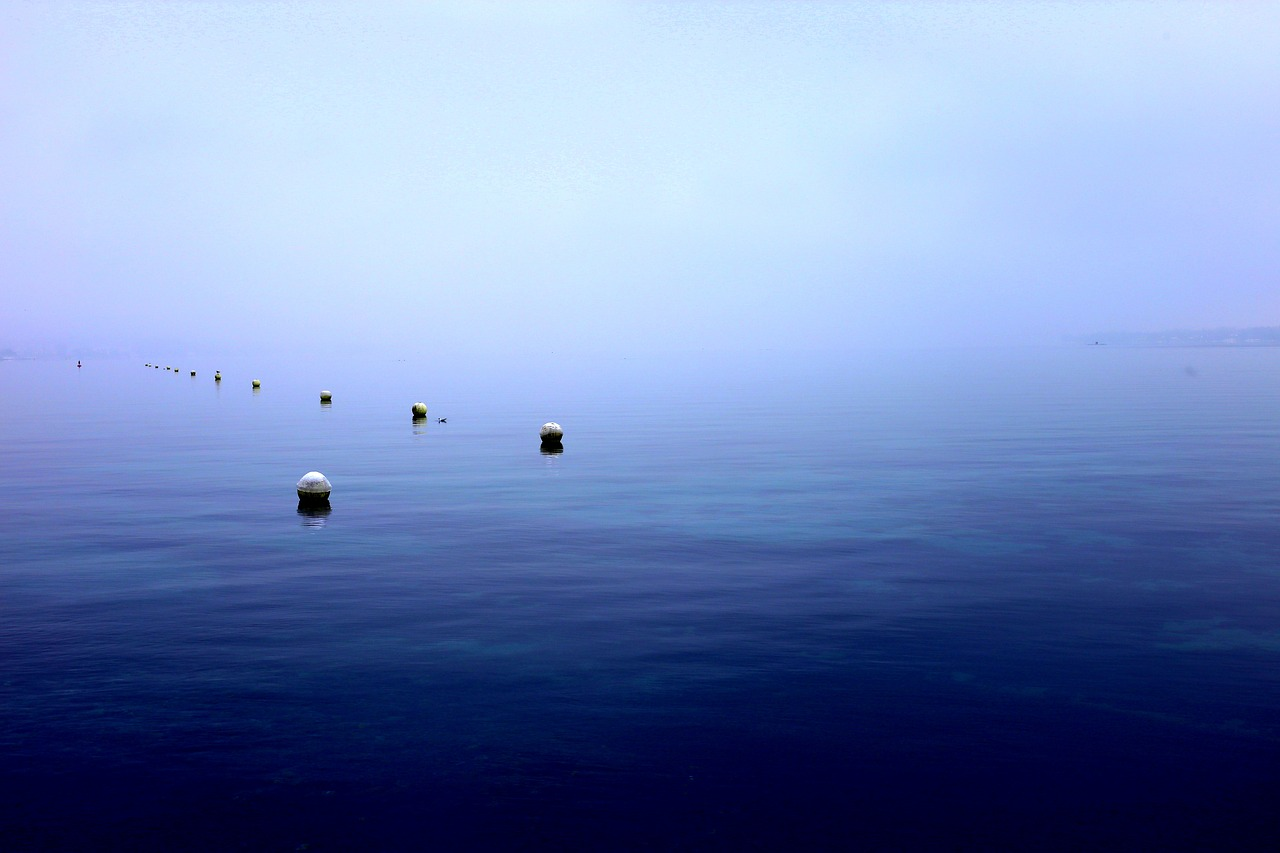

buoy


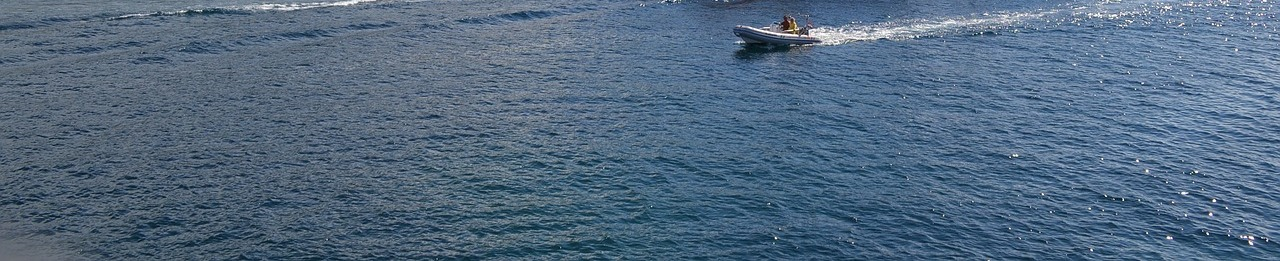

inflatable boat


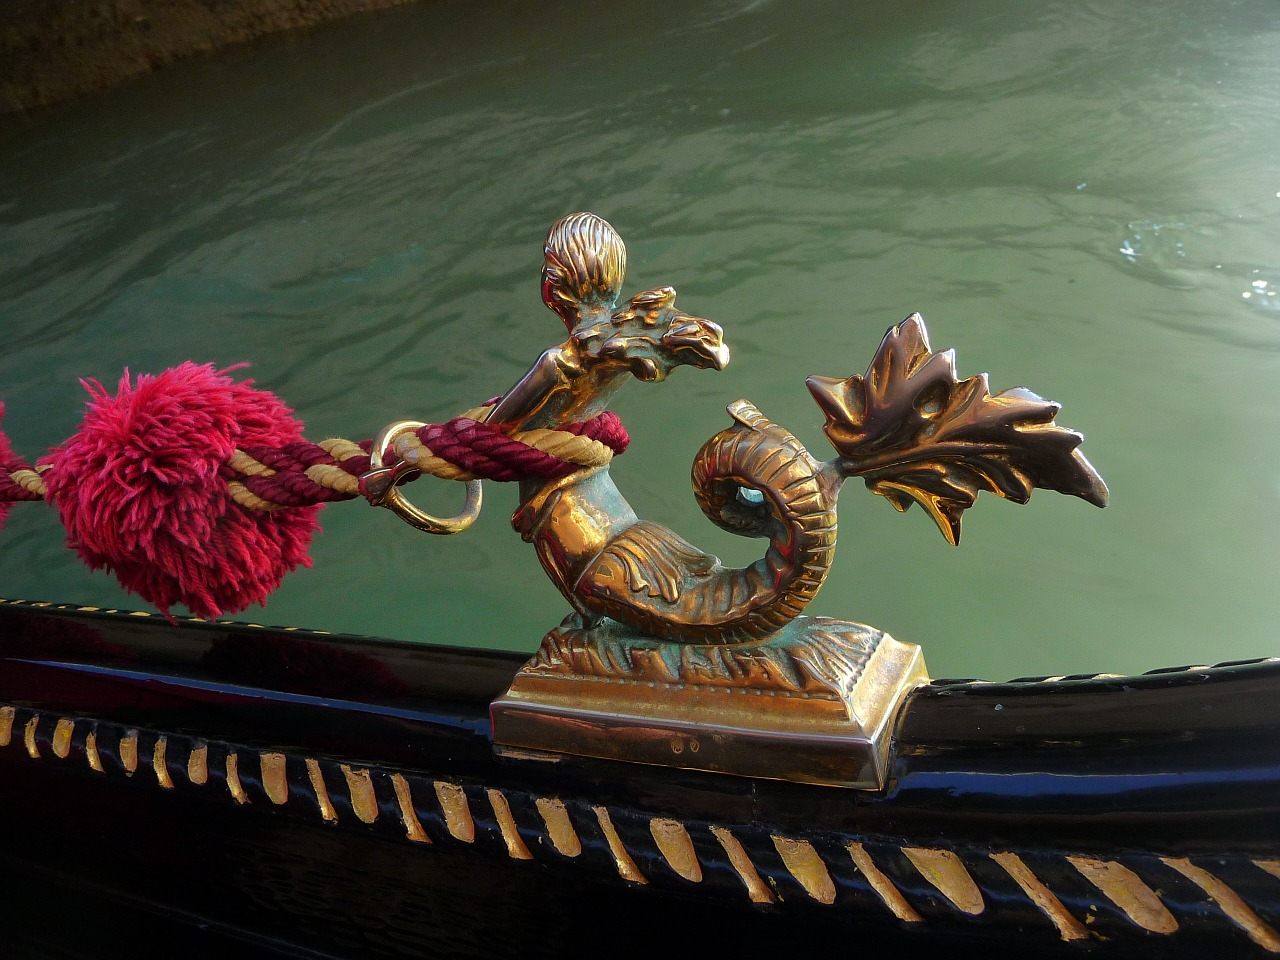

gondola


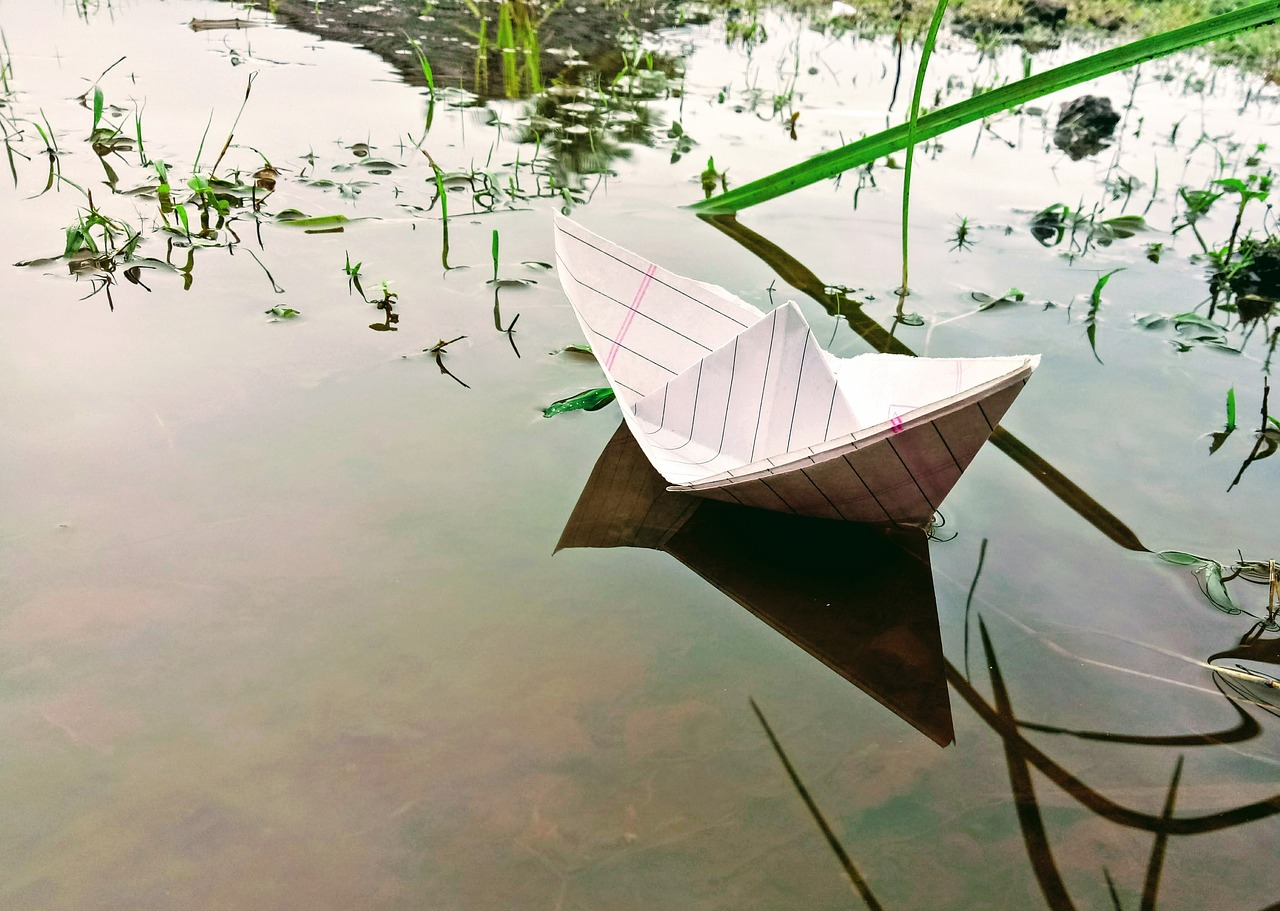

paper boat


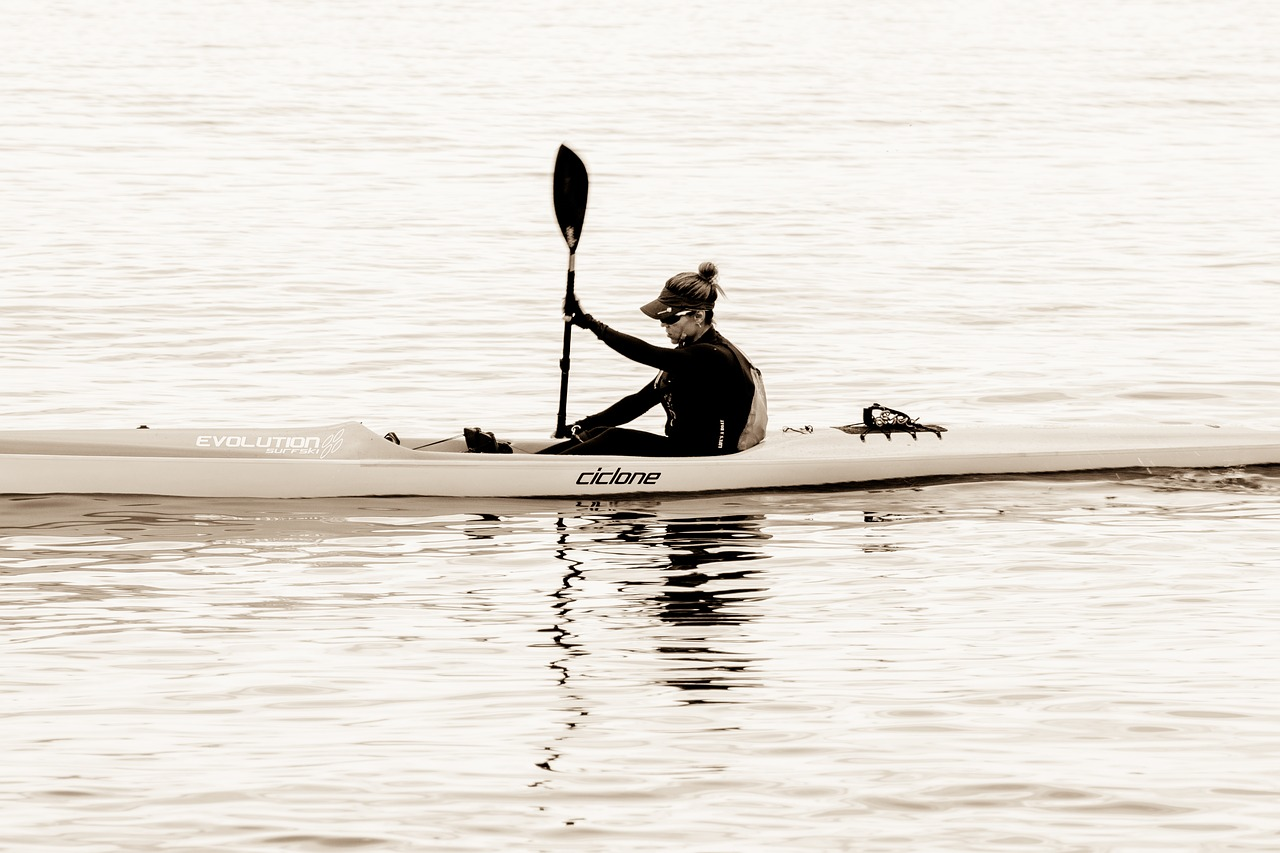

kayak


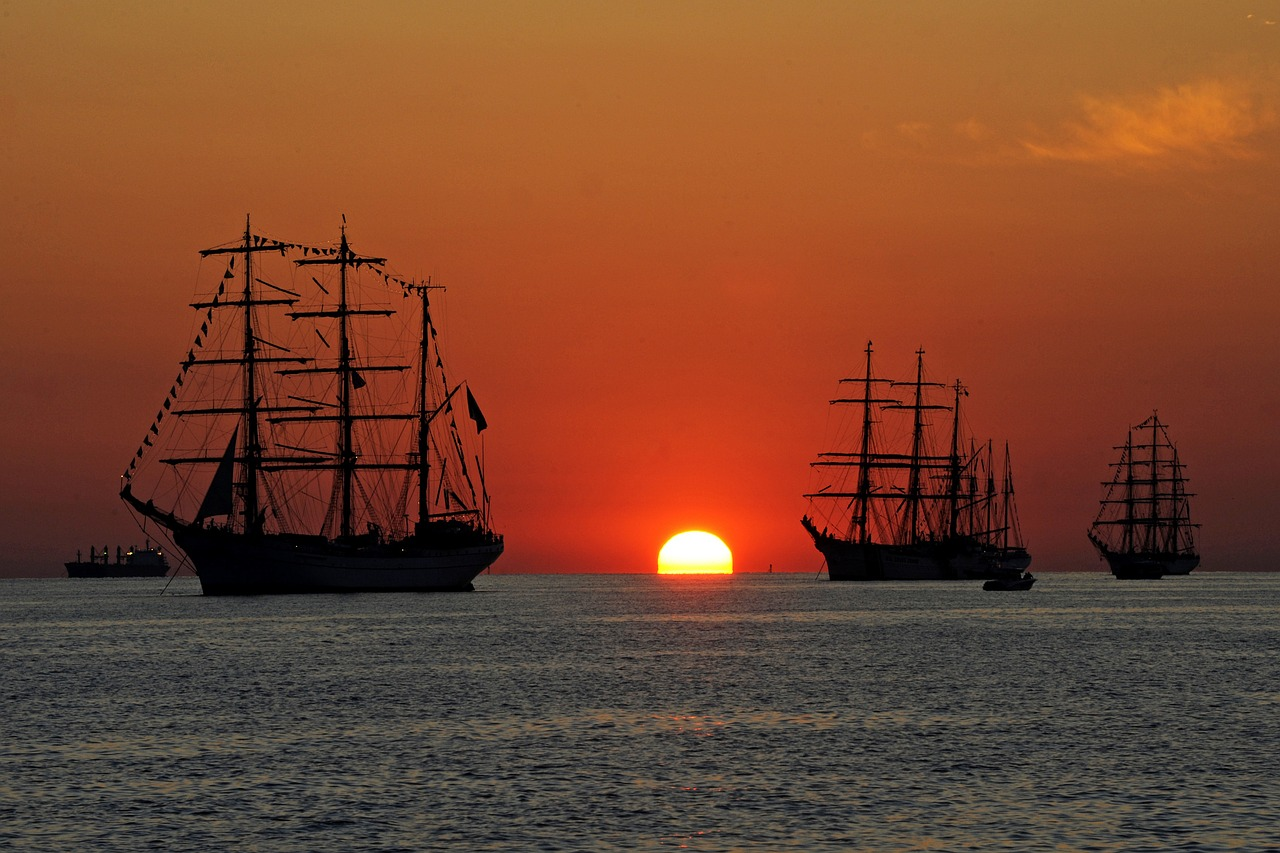

sailboat


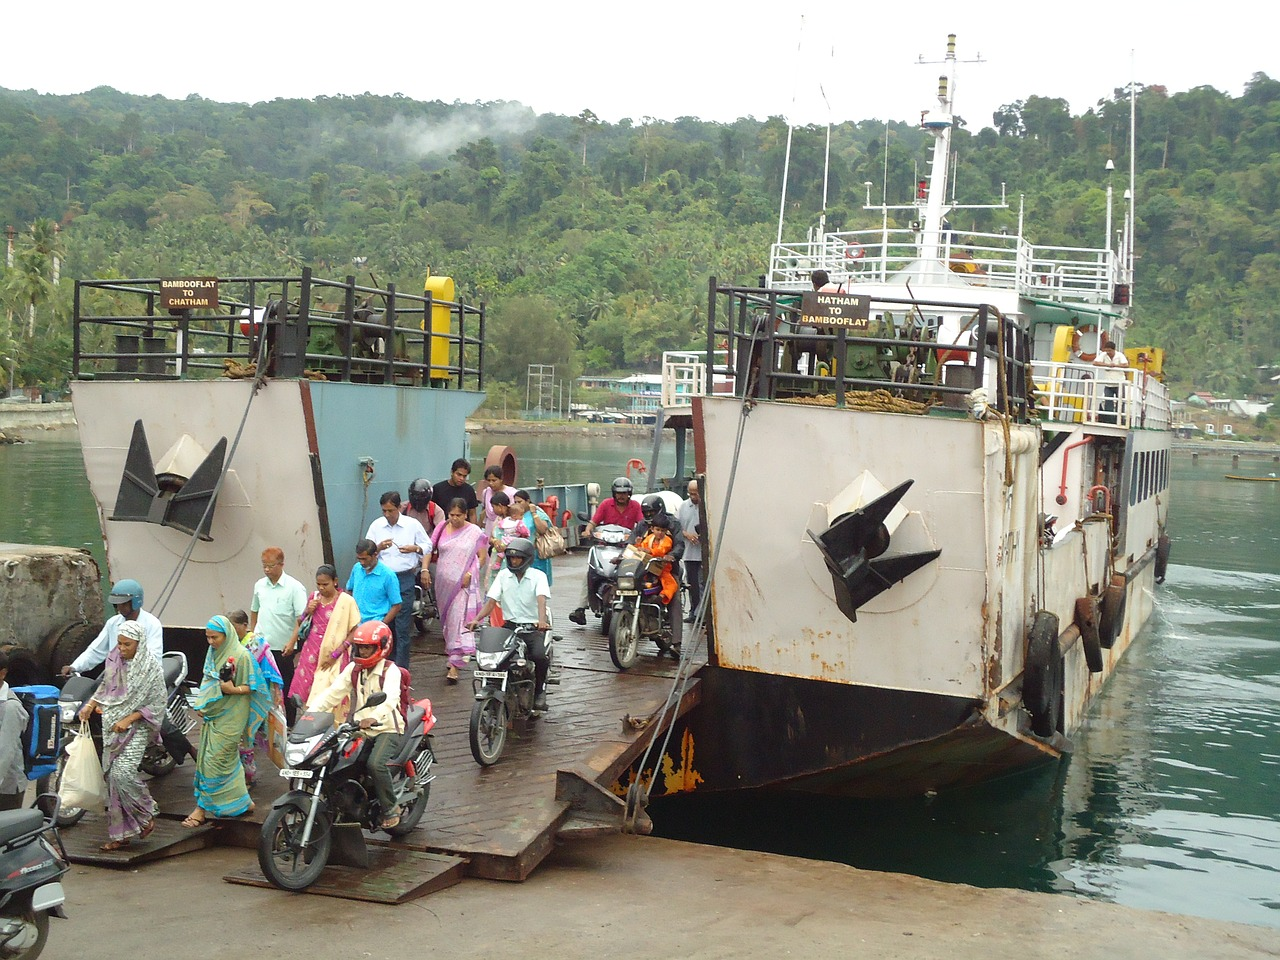

ferry boat


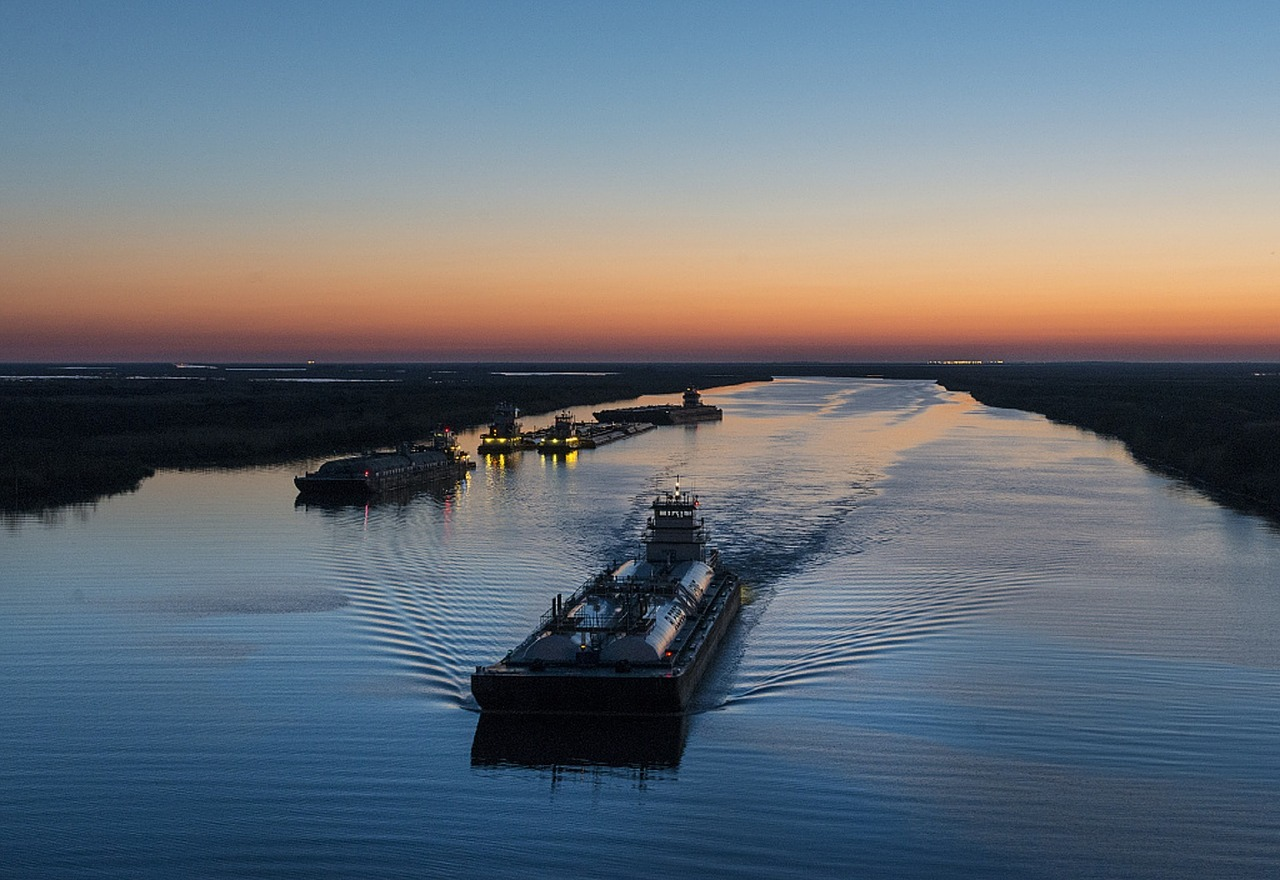

freight boat


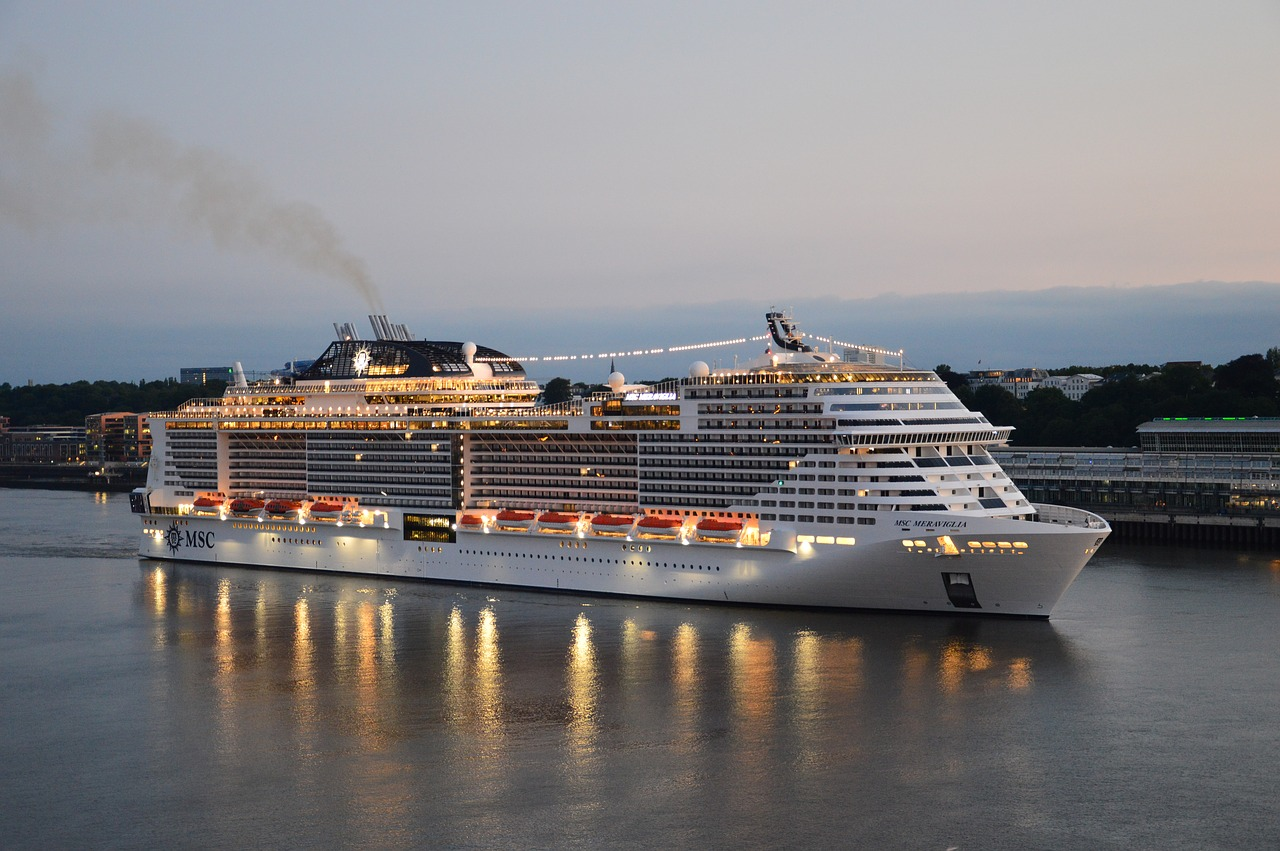

cruise ship


In [4]:
# plot one image per class in train set
for label in os.listdir('train'):
    img_path = 'train/' + label + '/' + np.random.choice(os.listdir('train'+'/' + label))
    display(Image(img_path, width = 300, height = 300))
    print(label)

# ResNet50

In [56]:
# load data
image_size = 224

# for training, use data augmentation
train_data_generator = ImageDataGenerator(
    preprocessing_function=resnet50.preprocess_input,
    horizontal_flip = True,
    rotation_range = 30,
    brightness_range = (0.8,1.2)
)

print('Training set')
train_generator = train_data_generator.flow_from_directory(
    'train',
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical')



data_generator = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
print('Validation set')
validation_generator = data_generator.flow_from_directory(
    'valid',
    target_size=(image_size, image_size),
    class_mode='categorical')

print('Test set')
test_generator = data_generator.flow_from_directory(
    'test',
    target_size=(image_size, image_size),
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

Training set
Found 864 images belonging to 9 classes.
Validation set
Found 299 images belonging to 9 classes.
Test set
Found 299 images belonging to 9 classes.


In [6]:
weights = 'imagenet'
num_classes = 9

# set network
my_new_model = Sequential()
my_new_model.add(ResNet50(include_top=False, pooling='avg', weights=weights))
my_new_model.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
my_new_model.layers[0].trainable = False

W0701 18:10:25.176612 4379919808 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
# compile
my_new_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [59]:
# set early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=True, 
    restore_best_weights=True
)

In [60]:
# train output layer of the model
my_new_model.fit_generator(
    train_generator,
    steps_per_epoch=4,
    epochs = 25,
    verbose = True,
    validation_data=validation_generator,
    validation_steps=1,
    callbacks = [early_stop]
)

Epoch 1/25
4/4 [==============================] - 26s 7s/step - loss: 1.8953 - acc: 0.3542 - val_loss: 1.0603 - val_acc: 0.7500
Epoch 2/25
4/4 [==============================] - 25s 6s/step - loss: 1.4834 - acc: 0.5312 - val_loss: 0.8836 - val_acc: 0.7500
Epoch 3/25
4/4 [==============================] - 21s 5s/step - loss: 1.3000 - acc: 0.6146 - val_loss: 0.8316 - val_acc: 0.7500
Epoch 4/25
4/4 [==============================] - 20s 5s/step - loss: 1.3741 - acc: 0.5625 - val_loss: 0.7771 - val_acc: 0.8438
Epoch 5/25
4/4 [==============================] - 22s 6s/step - loss: 1.1547 - acc: 0.6146 - val_loss: 0.6859 - val_acc: 0.8125
Epoch 6/25
4/4 [==============================] - 21s 5s/step - loss: 0.9665 - acc: 0.7083 - val_loss: 0.7178 - val_acc: 0.8125
Epoch 7/25
4/4 [==============================] - 20s 5s/step - loss: 1.2674 - acc: 0.5729 - val_loss: 0.6829 - val_acc: 0.8438
Epoch 8/25
4/4 [==============================] - 21s 5s/step - loss: 0.8929 - acc: 0.7500 - val_loss: 0

## ResNet50 - Predictions on test set

In [61]:
y_true = [labels[k] for k in test_generator.labels]  

In [62]:
test_generator.reset()
pred = my_new_model.predict_generator(test_generator,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

y_pred = [labels[k] for k in predicted_class_indices]

299/299 [==============================] - 48s 160ms/step


In [63]:
print('Accuracy Model on test set',np.round(accuracy_score(y_true,y_pred)*100,2),'%')
print('Accuracy Random Prediction',np.round((1/num_classes)*100,2),'%')

Accuracy Model on test set 76.92 %
Accuracy Random Prediction 11.11 %


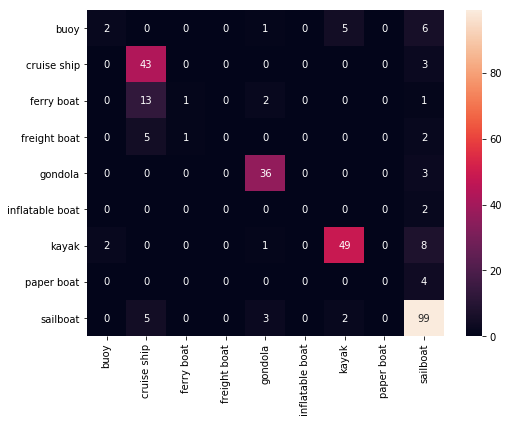

In [64]:
cm = confusion_matrix(y_true,y_pred)
lab_names = [labels[k] for k in range(num_classes)]

plt.figure(figsize = (8,6))
sn.heatmap(cm, annot=True,xticklabels=lab_names,yticklabels=lab_names)

# Xception

In [70]:
# load data
image_size = 224

# for training, use data augmentation
train_data_generator = ImageDataGenerator(
    preprocessing_function=xception.preprocess_input,
    horizontal_flip = True,
    rotation_range = 30,
    brightness_range = (0.8,1.2)
)

print('Training set')
train_generator = train_data_generator.flow_from_directory(
    'train',
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical')



data_generator = ImageDataGenerator(preprocessing_function=xception.preprocess_input)
print('Validation set')
validation_generator = data_generator.flow_from_directory(
    'valid',
    target_size=(image_size, image_size),
    class_mode='categorical')

print('Test set')
test_generator = data_generator.flow_from_directory(
    'test',
    target_size=(image_size, image_size),
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

Training set
Found 864 images belonging to 9 classes.
Validation set
Found 299 images belonging to 9 classes.
Test set
Found 299 images belonging to 9 classes.


In [71]:
weights = 'imagenet'
num_classes = 9

# set network
my_new_model = Sequential()
my_new_model.add(Xception(include_top=False, pooling='avg', weights=weights))
my_new_model.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
my_new_model.layers[0].trainable = False

83689472/83683744 [==============================] - 125s 1us/step


In [72]:
# compile
my_new_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [73]:
# set early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=True, 
    restore_best_weights=True
)

In [74]:
# train output layer of the model
my_new_model.fit_generator(
    train_generator,
    steps_per_epoch=4,
    epochs = 25,
    verbose = True,
    validation_data=validation_generator,
    validation_steps=1,
    callbacks = [early_stop]
)

Epoch 1/25
4/4 [==============================] - 36s 9s/step - loss: 2.1204 - acc: 0.1979 - val_loss: 1.7648 - val_acc: 0.3750
Epoch 2/25
4/4 [==============================] - 29s 7s/step - loss: 1.8696 - acc: 0.3438 - val_loss: 1.6289 - val_acc: 0.4688
Epoch 3/25
4/4 [==============================] - 28s 7s/step - loss: 1.6913 - acc: 0.3958 - val_loss: 1.5513 - val_acc: 0.5000
Epoch 4/25
4/4 [==============================] - 29s 7s/step - loss: 1.6384 - acc: 0.3750 - val_loss: 1.4617 - val_acc: 0.6562
Epoch 5/25
4/4 [==============================] - 26s 6s/step - loss: 1.6971 - acc: 0.4167 - val_loss: 1.3808 - val_acc: 0.6562
Epoch 6/25
4/4 [==============================] - 25s 6s/step - loss: 1.6486 - acc: 0.6042 - val_loss: 1.3592 - val_acc: 0.6562
Epoch 7/25
4/4 [==============================] - 24s 6s/step - loss: 1.5862 - acc: 0.5521 - val_loss: 1.2805 - val_acc: 0.6875
Epoch 8/25
4/4 [==============================] - 24s 6s/step - loss: 1.5516 - acc: 0.5625 - val_loss: 1

## Xception - Predictions on Test set

In [75]:
y_true = [labels[k] for k in test_generator.labels]  

In [76]:
test_generator.reset()
pred = my_new_model.predict_generator(test_generator,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

y_pred = [labels[k] for k in predicted_class_indices]

299/299 [==============================] - 62s 207ms/step


In [77]:
print('Accuracy Model on test set',np.round(accuracy_score(y_true,y_pred)*100,2),'%')
print('Accuracy Random Prediction',np.round((1/num_classes)*100,2),'%')

Accuracy Model on test set 76.25 %
Accuracy Random Prediction 11.11 %


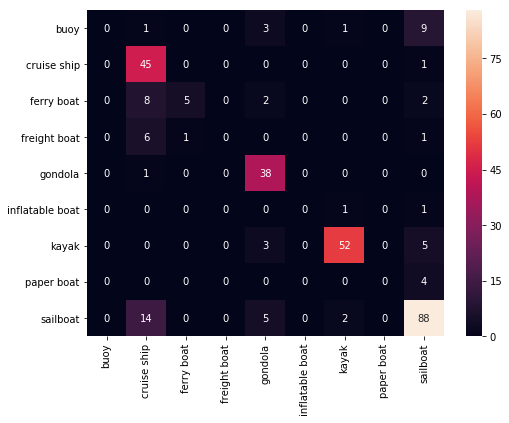

In [78]:
cm = confusion_matrix(y_true,y_pred)
lab_names = [labels[k] for k in range(num_classes)]

plt.figure(figsize = (8,6))
sn.heatmap(cm, annot=True,xticklabels=lab_names,yticklabels=lab_names)